# Model Evaluation Pipeline
**Please review the code cell below. At a minimum, you must enter a directory where output should be saved, and also tell this notebook where your model data is**. Then just run the notebook.

Look for the .txt and .output files in your working directly. Those are the results.

This pipeline is heavily reliant on other functions scattered throughout the repo, so please be sure you haven't moved it anywhere else. It is also heavily reliant on the model structure and output files generated during training with our base code. It is finicky enough that if you have any issues, it's probably easiest to just ask me to fix it (or at least show me the error).

In [29]:
# Enter the directory where you would like final result files to be saved.
WORKING_DIR = 'C:/Users/eweeding/Documents/MSE/DeepLearning/FinalProject'

# Now create a dictionary of lists with info on the models you want to compare
# Format is: { model_name_str : [model_pt_path, model_bin_path] }
# You can add as many as you want! Theoretically.
model_list = {}
model_list['KindaTrainedRNN'] = [WORKING_DIR+'/model_mini.pt', WORKING_DIR+'/model_mini.bin']
model_list['BabyLCRNN'] = [WORKING_DIR+'/lcrnn_mini.pt', WORKING_DIR+'/lcrnn_mini.bin']
model_list['BabyRNN'] = [WORKING_DIR+'/rnn-mini-model.pt', WORKING_DIR+'/rnn-mini-data.bin']

# Set analysis mode. Options are 'overall' (default) or 'full'
#MODE = 'overall'
MODE = 'full'

# If ANIM == True, examine the effects of animacy on the results. Default is False.
ANIM = True

# If NPI_SKIP == True, skip analysis of NPI
NPI_SKIP = True

### OPTIONAL ###
# Other paths you may need or want to change depending on your setup:
TEMPLATE_DIR = './EMNLP2018/templates' # Location where the paired sentence dataset should be
OUTPUT_FILE = 'all_test_sents.txt'     # Name of .txt file which will contain all test sentences, saved in TEMPLATE_DIR
MODEL_TYPE = 'RNN'                     # Model type. For now, only single-task RNN is supported, so don't change this.

## Step 0: Setup

In [2]:
# Import statements
import logging
import math
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd
import sys
import torch
import torch.nn as nn
from torch.autograd import Variable
from src.tester.TestWriter import TestWriter
from src.template.TestCases import TestCase

# Import a module within the base code
# Pathing workaround due to hyphens in folder name
sys.path.append(os.path.join(os.getcwd(), 'word-language-model'))
import data

# Suppress some intermediate messages
logging.disable(sys.maxsize)

# Check for GPU
gpu_avail = torch.cuda.is_available()
print('GPU available:', gpu_avail)

GPU available: True


## Step 1: Generate paired sentences
This generates the sentences for testing. These already exist in `./EMNLP2018/templates`, but you may need to generate them yourself if Pickle is behaving strangely with the downloaded files based on your OS.

In [3]:
%run ./src/make_templates.py $TEMPLATE_DIR

case: obj_rel_across_anim
case: obj_rel_within_anim
case: obj_rel_across_inanim
case: obj_rel_within_inanim
case: subj_rel
case: prep_anim
case: prep_inanim
case: obj_rel_no_comp_across_anim
case: obj_rel_no_comp_within_anim
case: obj_rel_no_comp_across_inanim
case: obj_rel_no_comp_within_inanim
case: simple_agrmt
case: sent_comp
case: vp_coord
case: long_vp_coord
case: reflexives_across
case: simple_reflexives
case: reflexive_sent_comp
case: npi_across_anim
case: npi_across_inanim
case: simple_npi_anim
case: simple_npi_inanim


## Step 2: Test a model on the sentences

In [4]:
# Functions for calculating complexity measures
def get_entropy(o):
    probs = nn.functional.softmax(o,dim=0)
    logprobs = nn.functional.log_softmax(o,dim=0)
    return -1 * torch.sum(probs * logprobs)


def get_surps(o):
    logprobs = nn.functional.log_softmax(o,dim=0)
    return -1 * logprobs


def get_complexity_apply(o,t,sentid,corpus,model_name,tags=False):
    Hs = torch.squeeze(apply(get_entropy,o))
    surps = apply(get_surps,o)    
    for corpuspos, targ in enumerate(t):
        if tags:
            word = corpus.dictionary.idx2tag[int(targ)]
        else:
            word = corpus.dictionary.idx2word[int(targ)]
        if word == '<eos>' or word == '<EOS>':
            # Don't output the complexity of EOS
            continue
        surp = surps[corpuspos][int(targ)]        
        with open(WORKING_DIR+'/'+model_name+'.output', 'a') as f:
            f.write('\n' + str(word)+' '+str(sentid)+' '+str(corpuspos)+' '+str(len(word))+' '+str(float(surp))+' '+str(float(Hs[corpuspos])))

            
def apply(func, M):
    tList = [func(m) for m in torch.unbind(M,dim=0) ]
    res = torch.stack(tList)
    return res


In [5]:
# Core testing functions
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)  
    
    
def test_get_batch(source, evaluation=False):
    if isinstance(source, tuple):
        seq_len = len(source[0]) - 1
        data = Variable(source[0][:seq_len], requires_grad=False)
        target = Variable(source[1][:seq_len], requires_grad=False)
    else:
        seq_len = len(source) - 1
        data = Variable(source[:seq_len], requires_grad=False)
        target = Variable(source[1:1+seq_len].view(-1))
    if gpu_avail:
        return data.cuda(), target.cuda()
    else:
        return data, target

    
def test_evaluate(test_lm_sentences, test_ccg_sentences, lm_data_source, ccg_data_source, model, model_name, corpus):
    model.eval()
    criterion = nn.CrossEntropyLoss()    
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    with open(WORKING_DIR+'/'+model_name+'.output', 'w') as f:
        f.write('word sentid sentpos wlen surp entropy')    

    for i in range(len(lm_data_source)+len(ccg_data_source)):
        if i % 1000 == 0:
            print(f'{i} / {len(lm_data_source)} sentences')
            
        if i >= len(lm_data_source):
            sent_ids = ccg_data_source[i-len(lm_data_source)]
            sent = test_ccg_sentences[i-len(lm_data_source)]
        else:
            sent_ids = lm_data_source[i]
            sent = test_lm_sentences[i]
            
        if gpu_avail:
            sent_ids = sent_ids.cuda()
            
        hidden = model.init_hidden(1)
        data, targets = test_get_batch(sent_ids, evaluation=True)
        data = data.unsqueeze(1)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntokens)
        curr_loss = criterion(output_flat, targets).item()
        total_loss += curr_loss

        # Get word-level complexity metrics
        if i >= len(lm_data_source):
            get_complexity_apply(output_flat,targets,i-len(lm_data_source),corpus,model_name,tags=True)
        else:
            get_complexity_apply(output_flat,targets,i,corpus,model_name)
        hidden = repackage_hidden(hidden)

    return total_loss / (len(lm_data_source)+len(ccg_data_source))


In [6]:
# A main function that coordinates testing
def run_main(model_name, save, save_lm_data, lm_data, testfname):
    corpus = data.SentenceCorpus(lm_data, False, save_lm_data, True, testfname=testfname)
    test_lm_sentences, test_lm_data = corpus.test_lm
    test_ccg_sentences = []
    test_ccg_data = []    

    # Load the saved model
    if gpu_avail:
        model = torch.load(save, map_location = 'cuda:0')
    else:
        model = torch.load(save, map_location = 'cpu')    
    print(model)    

    # Run on test data
    test_loss = test_evaluate(test_lm_sentences, test_ccg_sentences, test_lm_data, test_ccg_data, model, model_name, corpus)
    print('End of testing. Test Loss {:5.2f} | Test PPL {:8.2f}'.format(test_loss, math.exp(test_loss)))


In [7]:
# Final functions to combine model testing and scoring on sentences
def score_rnn(model_name):
    print('Scoring '+model_name)
    with open(WORKING_DIR+'/'+model_name+'.output', 'r') as f:
        all_scores = {}
        first = False
        score = 0.
        sent = []
        prev_sentid = -1
        for line in f:
            if not first:
                first = True
                continue
            if first and len(line.strip().split()) == 6 and "torch.cuda" not in line:
                wrd, sentid, wrd_score = [line.strip().split()[i] for i in [0,1,4]]
                score = -1 * float(wrd_score) # multiply by -1 to turn surps back into logprobs
                sent.append((wrd, score))
                if wrd == ".":
                    name_found = False                    
                    for (k1,v1) in sorted(name_lengths.items(), key=operator.itemgetter(1)):
                        if float(sentid) < v1 and not name_found:
                            name_found = True
                            if k1 not in all_scores:
                                all_scores[k1] = {}
                            key_found = False
                            for (k2,v2) in sorted(key_lengths[k1].items(), key=operator.itemgetter(1)):
                                if int(sentid) <  v2 and not key_found:
                                    key_found = True
                                    if k2 not in all_scores[k1]:
                                        all_scores[k1][k2] = []
                                    all_scores[k1][k2].append(sent)
                    sent = []
                    prev_sentid = float(sentid)
    return all_scores


def test_LM(model_name, model_files):      
    print('Testing '+model_name)
    run_main(model_name, model_files[0], model_files[1], TEMPLATE_DIR, OUTPUT_FILE)
    results = score_rnn(model_name)
    with open(WORKING_DIR+'/'+model_name+'_results.pickle', 'wb') as f:
        pickle.dump(results, f)
    print('End of scoring.\n')


In [8]:
# Select constructions to test (automatically selects all)
writer = TestWriter(TEMPLATE_DIR, OUTPUT_FILE)
testcase = TestCase()
tests = testcase.all_cases
all_test_sents = {}
for test_name in tests:
    test_sents = pickle.load(open(TEMPLATE_DIR+"/"+test_name+".pickle", 'rb'))
    all_test_sents[test_name] = test_sents
writer.write_tests(all_test_sents, 'word')
name_lengths = writer.name_lengths
key_lengths = writer.key_lengths

# Finally, proceed with testing the model(s)
for model_name, model_files in model_list.items():
    test_LM(model_name, model_files)

Testing KindaTrainedRNN
RNNModel(
  (drop): Dropout(p=0.2, inplace=False)
  (encoder): Embedding(50001, 200)
  (rnn): LSTM(200, 200, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=200, out_features=50001, bias=True)
)
0 / 11916 sentences
1000 / 11916 sentences
2000 / 11916 sentences
3000 / 11916 sentences
4000 / 11916 sentences
5000 / 11916 sentences
6000 / 11916 sentences
7000 / 11916 sentences
8000 / 11916 sentences
9000 / 11916 sentences
10000 / 11916 sentences
11000 / 11916 sentences
End of testing. Test Loss  7.12 | Test PPL  1236.42
Scoring KindaTrainedRNN
End of scoring.

Testing BabyLCRNN
RNNModel(
  (drop): Dropout(p=0.2, inplace=False)
  (encoder): Embedding(43508, 10)
  (rnn): LSTM(10, 10, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=10, out_features=43508, bias=True)
  (LCLs_after_recurrent_unit): LocallyConnectedLayer1d()
)
0 / 11916 sentences
1000 / 11916 sentences
2000 / 11916 sentences
3000 / 11916 sentences
4000 / 11916 sentences
5000 / 11916 

## Step 3: Analyze the results

In [9]:
# Functions for higher level interpretation of model results
def is_more_probable(sent_a, sent_b):
    if len(sent_a) != len(sent_b):
        print("ERROR: Mismatch in sentence lengths: (1) "+sent_a+" vs (2) "+sent_b)
    return sum([sent_a[i][1] for i in range(len(sent_a))]) > sum([sent_b[i][1] for i in range(len(sent_b))])


def analyze_agrmt_results(results):
    correct_sents = {}
    incorrect_sents = {}
    for case in results.keys():
        correct_sents[case] = []
        incorrect_sents[case] = []
        for i in range(0,len(results[case]),2):
            grammatical = results[case][i]
            ungrammatical = results[case][i+1]
            if is_more_probable(grammatical, ungrammatical):
                correct_sents[case].append((grammatical, ungrammatical))
            else:
                incorrect_sents[case].append((grammatical, ungrammatical))
    return correct_sents, incorrect_sents


def analyze_npi_results(results):
    options = ['gi_g', 'gi_i','iu_i','iu_u','gu_g','gu_u']
    sentences = {}
    for opt in options:
        sentences[opt] = {}
        for case in results.keys():
            sentences[opt][case] = []
    for case in results.keys():
        for i in range(0,len(results[case]),3):
            grammatical = results[case][i]
            intrusive = results[case][i+1]
            ungrammatical = results[case][i+2]
            g_sent = grammatical
            i_sent = intrusive
            u_sent = ungrammatical
            if is_more_probable(grammatical, intrusive):
                sentences['gi_g'][case].append((g_sent, i_sent, u_sent))
            else:
                sentences['gi_i'][case].append((g_sent, i_sent, u_sent))
            if is_more_probable(grammatical, ungrammatical):
                sentences['gu_g'][case].append((g_sent, i_sent, u_sent))
            else:
                sentences['gu_u'][case].append((g_sent, i_sent, u_sent))
            if is_more_probable(intrusive, ungrammatical):
                sentences['iu_i'][case].append((g_sent, i_sent, u_sent))
            else:
                sentences['iu_u'][case].append((g_sent, i_sent, u_sent))
    return [sentences[x] for x in options]


def display_agrmt_results(name, sents, model_name):
    correct_sents, incorrect_sents = sents
    overall_correct = 0.
    total = 0.
    strings = {}
    case_accs = {}
    for case in correct_sents.keys():
        if MODE == 'full':
            string = ""
            if len(correct_sents[case]) > 0:
                for i in range(len(correct_sents[case][0][0])):
                    if correct_sents[case][0][0][i][0] == correct_sents[case][0][1][i][0]:
                        string += correct_sents[case][0][0][i][0] + " "
                    else: string += correct_sents[case][0][0][i][0]+"/*"+correct_sents[case][0][1][i][0]+" "
            else:
                for i in range(len(incorrect_sents[case][0][0])):
                    if incorrect_sents[case][0][0][i][0] == incorrect_sents[case][0][1][i][0]:
                        string += incorrect_sents[case][0][0][i][0] + " "
                    else: string += incorrect_sents[case][0][0][i][0]+"/*"+incorrect_sents[case][0][1][i][0]+" "
            strings[case] = string[:-1]
            case_accs[case] = float(len(correct_sents[case]))/(len(correct_sents[case])+len(incorrect_sents[case]))
        overall_correct += len(correct_sents[case])
        total += len(correct_sents[case]) + len(incorrect_sents[case])
        
    # Case-by-case accuracies
    if MODE == 'full':
        case_out = open(WORKING_DIR+'/'+model_name+'_case_accs.txt', 'w')
        case_out.write("\n##########\n" + name + "\n##########\n"+"Overall acc: "+str(float(overall_correct)/total)+"\n")
        for (case,score) in sorted(case_accs.items(), key=operator.itemgetter(1)):
            case_out.write(str(case)+":\n")
            case_out.write(strings[case]+": "+str(round(score,4))+"\n")
        case_out.write("\n")
        case_out.close()
        
    # Individual scores
    if MODE == 'full':
        fout = open(WORKING_DIR+'/'+model_name+'_individual_accs.txt', 'w')
        fout.write("\n##########\n" + name + "\n##########\n\n")
        fout.write("Examples that the LM predicts incorrectly:\n")
        for case in incorrect_sents.keys():
            count = 0
            fout.write(case+":\n")
            for good, bad in incorrect_sents[case]:
                if count < 5:
                    fout.write("Grammatical:"+str(round(sum([x[1] for x in good]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in good])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in good])+"\n")
                    fout.write("Ungrammatical:"+str(round(sum([x[1] for x in bad]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in bad])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in bad])+"\n")
                    count += 1
                else:
                    break
        fout.write("\n")
        fout.close()
    return float(overall_correct)/total


def display_npi_results(name, sents, model_name):
    gi_grammatical_sents, gi_intrusive_sents, iu_intrusive_sents, iu_ungrammatical_sents, gu_grammatical_sents, gu_ungrammatical_sents = sents
    overall_gi = 0.
    overall_iu = 0.
    overall_gu= 0.
    total_gi = 0.
    total_iu = 0.
    total_gu = 0.
    strings = {}
    gi_case_accs = {}
    iu_case_accs = {}
    gu_case_accs = {}
    for case in gi_grammatical_sents.keys():
        gi_case_accs[case] = {}
        iu_case_accs[case] = {}
        gu_case_accs[case] = {}        
        if MODE == 'full':
            if len(gi_grammatical_sents[case]) > 0:
                string = ' '.join([x[0] for x in gi_grammatical_sents[case][0][0]]) + " vs. " + ' '.join([x[0] for x in gi_grammatical_sents[case][0][1]]) + " vs. " + ' '.join([x[0] for x in gi_grammatical_sents[case][0][2]])
            else:
                string = ' '.join([x[0] for x in gi_intrusive_sents[case][0][0]]) + " vs. " + ' '.join([x[0] for x in gi_intrusive_sents[case][0][1]]) + " vs. " + ' '.join([x[0] for x in gi_intrusive_sents[case][0][2]])
            strings[case] = string
            gi_case_accs[case] = float(len(gi_grammatical_sents[case]))/(len(gi_grammatical_sents[case])+len(gi_intrusive_sents[case]))
            iu_case_accs[case] = float(len(iu_intrusive_sents[case]))/(len(iu_intrusive_sents[case])+len(iu_ungrammatical_sents[case]))
            gu_case_accs[case] = float(len(gu_grammatical_sents[case]))/(len(gu_grammatical_sents[case])+len(gu_ungrammatical_sents[case]))
        overall_gi += len(gi_grammatical_sents[case])
        overall_iu += len(iu_intrusive_sents[case])
        overall_gu += len(gu_grammatical_sents[case])
        total_gi += len(gi_grammatical_sents[case]) + len(gi_intrusive_sents[case])
        total_iu += len(iu_intrusive_sents[case]) + len(iu_ungrammatical_sents[case])
        total_gu += len(gu_grammatical_sents[case]) + len(gu_ungrammatical_sents[case])
        
    # Case-by-case accuracies
    if MODE == 'full':
        case_out = open(WORKING_DIR+'/'+model_name+'_case_accs.txt', 'a')
        case_out.write("\n##########\n" + name + "\n##########\n" + "Overall acc:\n")
        case_out.write("OVERALL P(GRAMMATICAL) > P(INTRUSIVE): "+str(float(overall_gi)/total_gi)+"\n")
        case_out.write("OVERALL P(INTRUSIVE) > P(UNGRAMMATICAL): "+str(float(overall_iu)/total_iu)+"\n")
        case_out.write("OVERALL P(GRAMMATICAL) > P(UNGRAMMATICAL): "+str(float(overall_gu)/total_gu)+"\n")
        for (case,score) in sorted(gi_case_accs.items(), key=operator.itemgetter(1)):
            case_out.write(str(case)+":\n")
            case_out.write(strings[case]+":\n")
            case_out.write("Grammatical > intrusive: "+str(round(score,4))+"\n")
            case_out.write("Grammatical > ungrammatical: "+str(gu_case_accs[case])+"\n")
            case_out.write("Intrusive > ungrammatical: "+str(iu_case_accs[case])+"\n")
        case_out.write("\n")
        case_out.close()
    
    # Individual scores
    if MODE == 'full':
        fout = open(WORKING_DIR+'/'+model_name+'_individual_accs.txt', 'a')
        fout.write("\n##########\n" + name + "\n##########\n\n")
        fout.write("Examples where the LM prefers the intrusive licensor over the grammatical case:\n")
        for case in gi_intrusive_sents.keys():
            count = 0
            fout.write(case+":\n")
            for c,i,u in gi_intrusive_sents[case]:
                if count < 5:
                    fout.write("grammatical:"+str(round(sum([x[1] for x in c]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in c])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in c])+"\n")
                    fout.write("intrusive:"+str(round(sum([x[1] for x in i]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in i])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in i])+"\n")
                    count += 1
                else:
                    break
        fout.write("\nExamples where the LM prefers the ungrammatical case over the intrusive licensor:\n")
        for case in iu_ungrammatical_sents.keys():
            count = 0
            fout.write(case+":\n")
            for c,i,u in iu_ungrammatical_sents[case]:
                if count < 5:
                    fout.write("intrusive:"+str(round(sum([x[1] for x in i]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in i])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in i])+"\n")
                    fout.write("ungrammatical:"+str(round(sum([x[1] for x in u]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in u])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in u])+"\n")
                    count += 1
                else:
                    break
        fout.write("\nExamples where the LM prefers the ungrammatical case over the grammatical case:\n")
        for case in gu_ungrammatical_sents.keys():
            count = 0
            fout.write(case+":\n")
            for c,i,u in gu_ungrammatical_sents[case]:
                if count < 5:
                    fout.write("grammatical:"+str(round(sum([x[1] for x in c]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in c])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in c])+"\n")
                    fout.write("ungrammatical:"+str(round(sum([x[1] for x in u]),2))+"\n")
                    fout.write('\t'.join([x[0] for x in u])+"\n")
                    fout.write('\t'.join([str(round(x[1],2)) for x in u])+"\n")
                    count += 1
                else:
                    break
        fout.write("\n")
        fout.close()
   
    return float(overall_gi)/total_gi, float(overall_iu)/total_iu, float(overall_gu)/total_gu


In [21]:
# Save a list of results for display later
display_results = {}

# Iterate through the models to run final analyses
for model_name, model_files in model_list.items():
    
    # Final model analysis
    results = pickle.load(open(WORKING_DIR+'/'+model_name+'_results.pickle', 'rb'))
    
    # Combine results w.r.t. animacy if desired
    if not ANIM:
        joined_results = {}
        for name in tests:
            if 'anim' in name:
                new_name = '_'.join(name.split("_")[:-1])
            else:
                new_name = name
            for sub_case in results[name]:
                if new_name not in joined_results:
                    joined_results[new_name] = {}
                if sub_case not in joined_results[new_name]:
                    joined_results[new_name][sub_case] = []
                joined_results[new_name][sub_case] += results[name][sub_case]
        pickle.dump(joined_results, open(WORKING_DIR+'/'+model_name+'_results.joined.pickle', 'wb'))
    else:
        joined_results = results
        
    # Display and save overall model results
    display_results[model_name] = []
    with open(WORKING_DIR+'/'+model_name+'_overall_accs.txt', 'w') as f:
        for name in joined_results.keys():
            if "npi" in name:                
                if NPI_SKIP:
                    continue
                sents = analyze_npi_results(joined_results[name])
                overall_gi, overall_iu, overall_gu = display_npi_results(name, sents, model_name)
                f.write(name+"(grammatical vs. intrusive): "+str(overall_gi)+"\n")
                f.write(name+"(intrusive vs. ungrammatical): "+str(overall_iu)+"\n")
                f.write(name+"(grammatical vs. ungrammatical): "+str(overall_gu)+"\n")
                display_results[model_name].append(overall_gi)
                display_results[model_name].append(overall_iu)
                display_results[model_name].append(overall_gu)
            else:
                sents = analyze_agrmt_results(joined_results[name])
                overall = display_agrmt_results(name, sents, model_name)
                f.write(name+": "+str(overall)+"\n")
                display_results[model_name].append(overall) 
     

## Step 4: Display results

In [22]:
# Extract row labels based on test cases
labels = []
for name in joined_results.keys():
    if 'npi' in name:
        if NPI_SKIP:
            continue
        labels.append(name+'(G_v_I)')
        labels.append(name+'(I_v_UG)')
        labels.append(name+'(G_v_UG)')
    else:
        labels.append(name)
        
# Create a dataframe of results and display it
df = pd.DataFrame(display_results, index=labels)

df

,KindaTrainedRNN,BabyLCRNN,BabyRNN
obj_rel_across_anim,0.509259,0.5,0.537037
obj_rel_within_anim,0.839506,0.5,0.570988
obj_rel_across_inanim,0.500000,0.5,0.589506
obj_rel_within_inanim,0.790123,0.5,0.574074
subj_rel,0.537037,0.5,0.490741
prep_anim,0.604938,0.5,0.524691
prep_inanim,0.703704,0.5,0.606481
obj_rel_no_comp_across_anim,0.506173,0.5,0.503086
obj_rel_no_comp_within_anim,0.703704,0.5,0.533951
obj_rel_no_comp_across_inanim,0.500000,0.5,0.496914


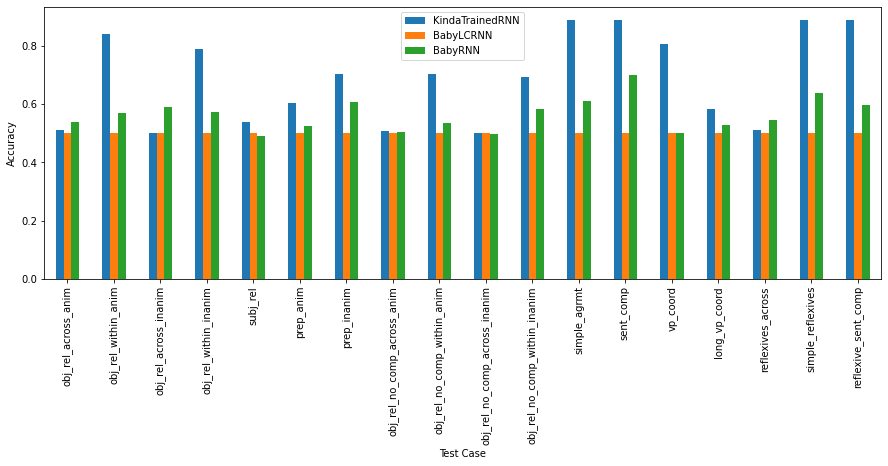

In [27]:
# Alternatively, show a nice bar plot
df.plot.bar(figsize=(15,5))
plt.ylabel('Accuracy')
plt.xlabel('Test Case')
plt.show()